In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
import numpy as np


In [4]:


def is_image_file(filename):
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
    return filename.lower().endswith(valid_extensions)

def load_images(folder, target_size=(190, 190)):
    images, labels = [], []
    
    if not os.path.exists(folder):
        print(f"Error: Path '{folder}' does not exist!")
        return images, labels, {}

    train_path = os.path.join(folder, "Training")
    test_path = os.path.join(folder, "Testing")

    all_folders = []
    if os.path.exists(train_path):
        all_folders.append(train_path)
    if os.path.exists(test_path):
        all_folders.append(test_path)

    class_dict = {}
    class_index = 0

    for main_folder in all_folders:
        class_names = [d for d in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, d))]
        
        for class_name in class_names:
            if class_name not in class_dict:
                class_dict[class_name] = class_index
                class_index += 1

            class_folder = os.path.join(main_folder, class_name)
            for filename in os.listdir(class_folder):
                if is_image_file(filename):
                    img_path = os.path.join(class_folder, filename)
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, target_size)
                        images.append(img)
                        labels.append(class_dict[class_name])
                    else:
                        print(f"Warning: Could not read {img_path}")

    images = np.array(images) / 255.0
    labels = np.array(labels)
    return images, labels, class_dict

X, y, class_map = load_images("/kaggle/input/brain-data/brain_data")
print(f"Loaded {len(X)} images with {len(class_map)} classes.")

Loaded 6595 images with 4 classes.


In [5]:



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_classes = len(np.unique(y_train))
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)


datagen = ImageDataGenerator(
    rotation_range=20,  
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    horizontal_flip=True,
    #zoom_range=0.2
)

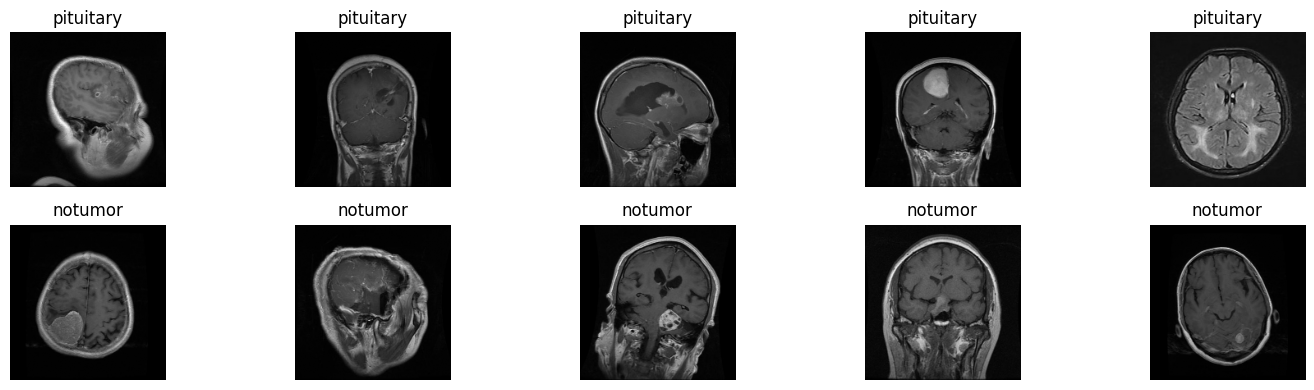

In [6]:



class_names = {v: k for k, v in class_map.items()}

def plot_images_by_label(X, y, class_names, samples_per_class=5):
    unique_labels = np.unique(y)
    
    plt.figure(figsize=(15, len(unique_labels) * 2))

    for i, label in enumerate(unique_labels):
        indices = np.where(y == label)[0]
        selected_indices = random.sample(list(indices), min(samples_per_class, len(indices)))

        for j, img_idx in enumerate(selected_indices):
            plt.subplot(len(unique_labels), samples_per_class, i * samples_per_class + j + 1)
            plt.imshow(X[img_idx])
            plt.title(class_names[label])
            plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_images_by_label(X_train, y_train, class_names, samples_per_class=5)


In [7]:

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(190, 190, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    
    Conv2D(512, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.6),  
    Dense(num_classes, activation='softmax')

])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 188, 188, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 188, 188, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 94, 94, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 92, 92, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 92, 92, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 44, 44, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 44, 44, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 20, 20, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 20, 20, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 2, 2, 128)           │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 2, 2, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,197,060 (8.38 MB)

 Trainable params: 2,194,820 (8.37 MB)

 Non-trainable params: 2,240 (8.75 KB)

In [8]:

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)



In [9]:

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=4),
    validation_data=(X_test, y_test),
    epochs=28,
    callbacks=[checkpoint, early_stop]  
)


Epoch 1/28


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1316/1319 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5280 - loss: 1.2570
Epoch 1: val_accuracy improved from -inf to 0.83397, saving model to best_model.keras
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 53s 32ms/step - accuracy: 0.5283 - loss: 1.2562 - val_accuracy: 0.8340 - val_loss: 0.4660
Epoch 2/28
1318/1319 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7236 - loss: 0.6985
Epoch 2: val_accuracy improved from 0.83397 to 0.83776, saving model to best_model.keras
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - accuracy: 0.7236 - loss: 0.6985 - val_accuracy: 0.8378 - val_loss: 0.3827
Epoch 3/28
1317/1319 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7915 - loss: 0.5186
Epoch 3: val_accuracy did not improve from 0.83776
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - accuracy: 0.7915 - loss: 0.5186 - val_accuracy: 0.7210 - val_loss: 0.7706
Epoch 4/28
1318/1319 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8262 - loss: 0.4550
Epoch 4: val_accuracy improved from 0.83776 to 0.86505, saving mod

In [10]:

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9757 - loss: 0.0636
Test Accuracy: 0.9795


In [11]:

test_loss, test_acc = model.evaluate(X_train, y_train)
print(f"Train Accuracy: {test_acc:.4f}")

165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9949 - loss: 0.0145
Train Accuracy: 0.9953


In [12]:

model.save("Brain_tumor_classification(binary)(3).h5")
print("Model saved as Brain_tumor_classification.h5")

Model saved as Brain_tumor_classification.h5


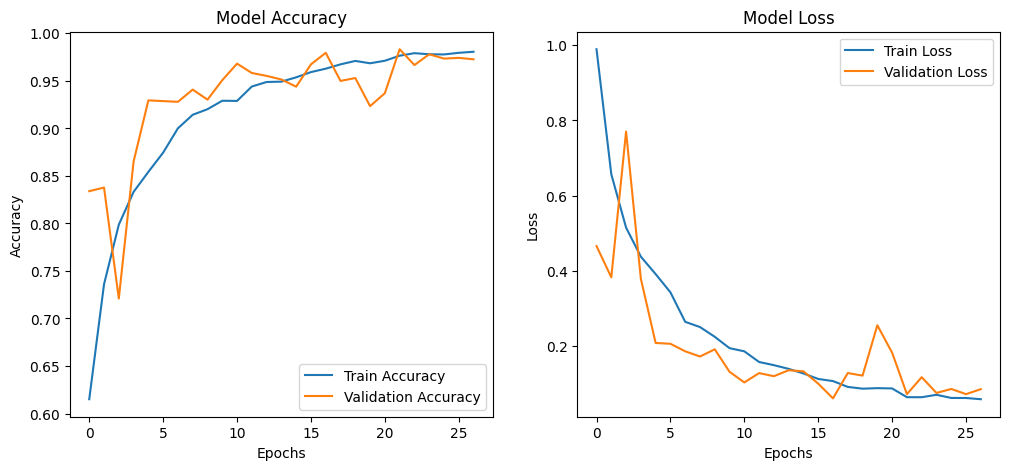

In [13]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


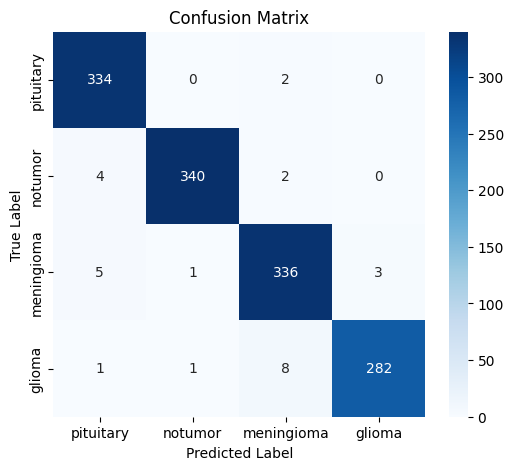

In [14]:



y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  
y_true = np.argmax(y_test, axis=1)  
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6, 5))
class_labels = list(class_map.keys())  
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [15]:

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_test shape: (1319, 190, 190, 3)
y_test shape: (1319, 4)


In [16]:


print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_map.keys()))

Classification Report:

              precision    recall  f1-score   support

   pituitary       0.97      0.99      0.98       336
     notumor       0.99      0.98      0.99       346
  meningioma       0.97      0.97      0.97       345
      glioma       0.99      0.97      0.98       292

    accuracy                           0.98      1319
   macro avg       0.98      0.98      0.98      1319
weighted avg       0.98      0.98      0.98      1319



In [17]:

y_pred_train = model.predict(X_train)
y_pred_train_classes = np.argmax(y_pred_train, axis=1)  
y_train_classes = np.argmax(y_train, axis=1)  
print("Training Classification Report:\n")
print(classification_report(y_train_classes, y_pred_train_classes, target_names=class_map.keys()))


165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Training Classification Report:

              precision    recall  f1-score   support

   pituitary       1.00      1.00      1.00      1285
     notumor       1.00      1.00      1.00      1380
  meningioma       0.99      0.99      0.99      1282
      glioma       1.00      0.99      0.99      1329

    accuracy                           1.00      5276
   macro avg       1.00      1.00      1.00      5276
weighted avg       1.00      1.00      1.00      5276



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step


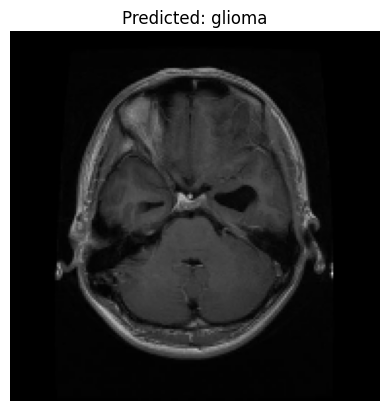

Predicted class: glioma


In [18]:

model = load_model("Brain_tumor_classification(binary)(3).h5")

index_to_class = {v: k for k, v in class_map.items()}

image_path = "/kaggle/input/brain-data/brain_data/Testing/glioma/Te-glTr_0004.jpg"

img = cv2.imread(image_path)
if img is None:
    raise ValueError(f"Could not load image: {image_path}")

img_resized = cv2.resize(img, (190, 190))
img_normalized = img_resized / 255.0
img_input = np.expand_dims(img_normalized, axis=0)

prediction = model.predict(img_input)
predicted_class_index = np.argmax(prediction)
predicted_class_name = index_to_class[predicted_class_index]

plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted: {predicted_class_name}")
plt.axis("off")
plt.show()

print(f"Predicted class: {predicted_class_name}")
